# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [2]:
import torch
import torch.nn as nn
from torch import Tensor
from torch.distributions import Normal

import numpy as np
import normflows as nf
import os
from tqdm import tqdm
from typing import *
from zuko.utils import odeint

from matplotlib import pyplot as plt

from jet_dataset import JetDataset

from typing import *
from zuko.utils import odeint

In [2]:
def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [ ]:
### code from https://gist.github.com/francois-rozet/fd6a820e052157f8ac6e2aa39e16c1aa ###

class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: List[int] = [64, 64],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])


class CNF(nn.Module):
    def __init__(
        self,
        features: int,
        freqs: int = 3,
        **kwargs,
    ):
        super().__init__()

        self.net = MLP(2 * freqs + features, features, **kwargs)

        self.register_buffer('freqs', torch.arange(1, freqs + 1) * torch.pi)

    def forward(self, t: Tensor, x: Tensor) -> Tensor:
        t = self.freqs * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)

        return self.net(torch.cat((t, x), dim=-1))

    def encode(self, x: Tensor) -> Tensor:
        return odeint(self, x, 0.0, 1.0, phi=self.parameters())

    def decode(self, z: Tensor) -> Tensor:
        return odeint(self, z, 1.0, 0.0, phi=self.parameters())

    def log_prob(self, x: Tensor) -> Tensor:
        I = torch.eye(x.shape[-1]).to(x)
        I = I.expand(x.shape + x.shape[-1:]).movedim(-1, 0)

        def augmented(t: Tensor, x: Tensor, ladj: Tensor) -> Tensor:
            with torch.enable_grad():
                x = x.requires_grad_()
                dx = self(t, x)

            jacobian = torch.autograd.grad(dx, x, I, is_grads_batched=True, create_graph=True)[0]
            trace = torch.einsum('i...i', jacobian)

            return dx, trace * 1e-2

        ladj = torch.zeros_like(x[..., 0])
        z, ladj = odeint(augmented, (x, ladj), 0.0, 1.0, phi=self.parameters())

        return Normal(0.0, z.new_tensor(1.0)).log_prob(z).sum(dim=-1) + ladj * 1e2


class FlowMatchingLoss(nn.Module):
    def __init__(self, v: nn.Module):
        super().__init__()

        self.v = v

    def forward(self, x: Tensor) -> Tensor:
        t = torch.rand_like(x[..., 0]).unsqueeze(-1)
        z = torch.randn_like(x)
        y = (1 - t) * x + (1e-4 + (1 - 1e-4) * t) * z
        u = (1 - 1e-4) * z - x

        return (self.v(t.squeeze(-1), y) - u).square().mean()


if __name__ == '__main__':
    flow = CNF(2, hidden_features=[256] * 3)

    # Training
    loss = FlowMatchingLoss(flow)
    optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)

    data, _ = make_moons(4096, noise=0.05)
    data = torch.from_numpy(data).float()

    for epoch in tqdm(range(4096), ncols=88):
        subset = torch.randint(0, len(data), (256,))
        x = data[subset]

        optimizer.zero_grad()
        loss(x).backward()
        optimizer.step()

    # Sampling
    with torch.no_grad():
        z = torch.randn(4096, 2)
        x = flow.decode(z).numpy()


    # Log-likelihood
    with torch.no_grad():
        log_p = flow.log_prob(data[:4])

    print(log_p)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
save_dir = './data/NF_2_jets15/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [5]:
###################################
### Define the Normalizing Flow ###
###################################

# Define flows
K = 10

latent_size = 1
hidden_units = 64
hidden_layers = 2
context_size = 16

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

In [6]:
#######################
### Define the data ###
#######################

batch_size = 131072

dataset = JetDataset("./jet_data",'train')
dataset_val = JetDataset("./jet_data",'val')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=10)

loaded model from ./data/NF_2_jets15/model_5499.pth


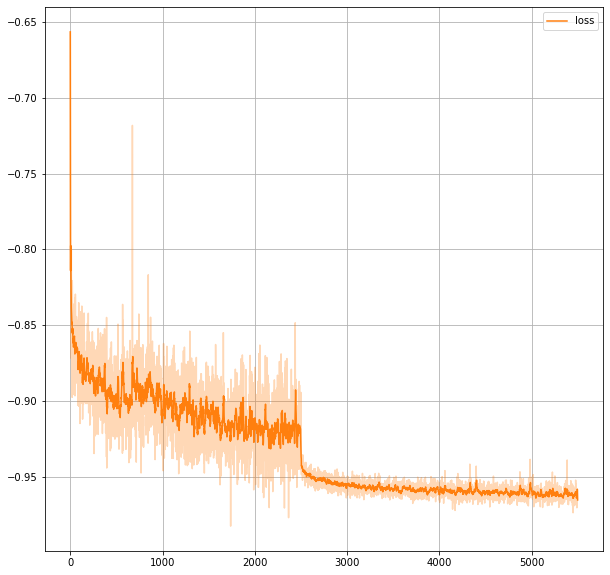

In [7]:
#####################
### Training Loop ###
#####################

train = False
lr = 1e-3
weight_decay = 0 
lr_decay = 1 #0.999

epochs = 5500

if train:
    optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, lr_decay)
    model.train()

    loss_hist = np.array([])

    for ep in tqdm(range(epochs)):
        optim.zero_grad()
        
        for x, c in dataloader:
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            
            # Compute loss
            loss = model.forward_kld(x, c)
            
            # Do backprop and optimizer step
            if ~(torch.isnan(loss) | torch.isinf(loss)):
                loss.backward()
                optim.step()
                scheduler.step()
            
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

        if ep%50 == 0:
            torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")

    model.eval()

    torch.save(model.state_dict(), save_dir + f"model_{ep}.pth")
    print('saved model at ' + save_dir + f"model_{ep}.pth")

else:
    ep = epochs-1

    with open(save_dir + f'losses_{ep}.npy', 'rb') as f:
        loss_hist = np.load(f)

    model.load_state_dict(torch.load(save_dir + f"model_{ep}.pth"))
    print('loaded model from ' + save_dir + f"model_{ep}.pth")


# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(smooth(loss_hist,1), color = 'C1', alpha = 0.3)
plt.plot(smooth(loss_hist,11), label='loss', color = 'C1')
plt.grid()
plt.legend()
img_outfile = save_dir + f"image_ep{ep}_loss.png"
plt.savefig(img_outfile)
plt.show()

plotting rocs


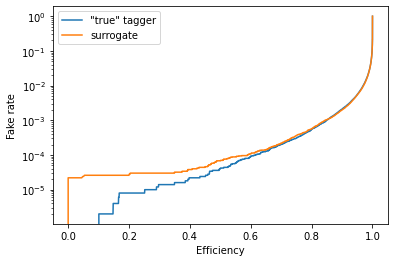

plotting raw (1000000, 1) torch.Size([1000000, 1])
plotting raw gen


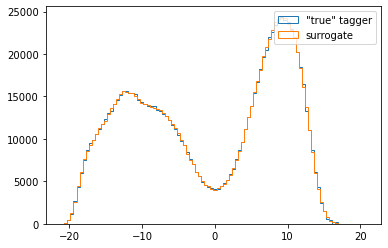

saved images at ./data/NF_2_jets15/


In [8]:
################
### Plotting ###
################

from sklearn.metrics import roc_curve

with torch.no_grad():
    # get a batch to compare
    conditions = torch.Tensor(dataset_val.features).to(device)
    
    bs = 1000 
    n_bs = len(conditions)//bs+1

    c_new = conditions[:bs]
    x_gen, _ = model.sample(bs, context=conditions[:bs])
    for i in range(n_bs-1):
        c_data = conditions[(i+1)*bs:(i+2)*bs]
        c_new = torch.concat((c_new, c_data), 0)
        x_gen_tmp, _ = model.sample(len(c_data), context=c_data)
        x_gen = torch.concat((x_gen, x_gen_tmp), 0)

    conditions = c_new
    x_gen = x_gen*20. #back to full scale
    x_gen_raw = x_gen #HIER SOLLTE NOCH GEMITTELT WERDEN ÜBER OUTPUTS ZUR SELBEN CONDITION
    x_gen = torch.sigmoid(x_gen)
    print("plotting rocs")
    fpr,tpr,_ = roc_curve(dataset_val.truth, dataset_val.raw_target)
    gfpr,gtpr,_ = roc_curve(dataset_val.truth, x_gen.cpu())
    plt.plot(tpr, fpr, label='"true" tagger')
    plt.plot(gtpr, gfpr, label='surrogate')
    plt.xlabel("Efficiency")
    plt.ylabel("Fake rate")
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}.png"
    plt.savefig(img_outfile)

    plt.yscale('log')
    img_outfile = save_dir + f"image_ep{ep}_log.png"
    plt.savefig(img_outfile)
    plt.show()

    print("plotting raw", dataset_val.target.shape, x_gen_raw.shape)
    _,b,_ = plt.hist(dataset_val.target[:,0]*20.,bins=100, label='"true" tagger',histtype='step')
    print("plotting raw gen")
    plt.hist(x_gen_raw.cpu().numpy()[:,0],bins=b, label='surrogate',histtype='step')
    plt.legend()
    img_outfile = save_dir + f"image_ep{ep}_raw.png"
    plt.savefig(img_outfile)
    plt.show()
    print('saved images at ' + save_dir)